Load libraries, define some functions

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)

## Visualizing single cell images

For each of the **215,081** single cell images in the dataset, we can visualize the raw intensities and segmentations for the DNA, membrane, and structure channel using the CFE (Cell Feature Explorer). Segmentations were computed at the FOV level using the Allen Cell and Structure Segmenter (Chen et al., 2018), with code and trained models available at https://github.com/AllenCell/segmenter_model_zoo. Single cells were extracted from the FOVs using the cell segmentation results. All images were rescaled to isotropic voxel sizes by interpolating along the z dimension to upscale the voxel size from 0.108333 $\mu$m x 0.108333 $\mu$m x 0.29 $\mu$m  to 0.108333 $\mu$m x 0.108333 $\mu$m x 0.108333 $\mu$m. ROIs were determined by extending the 3D bounding box of the cell by 40 pixels in x and y, and 10 pixels in z. 

In [3]:
# Sample a cell
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
some_cell = df.sample(1).iloc[0]


In [4]:
# Generate CFE URL
def generate_url(cell_id):
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={cell_id}")
cell_id = some_cell['CellId'].item() 
generate_url(cell_id)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=905555


Here, we can select *Full Field* at the top middle of the UI to switch to the FOV view.

For the sake of the challenge, single cell images were further preprocessed by merging in the cropped brightfield channel, centering and aligning the image to the longest axis of the membrane segmentation channel, and masking by the membrane segmentation channel. Images were further cropped and resized to a global 3D bounding box by taking the 95% quantile of the individual bounding box widths in x, y, and z. The columns **fits_z**, **fits_x**, **fits_y**, indicate whether the image fits the bounding box in that direction. Images that do fit the bounding box were padded with 0s, whereas the images that dont were cropped to that size (some information will be lost here, which may be relevant to the challenge). The final

In [13]:
df['success'].value_counts()

True    215081
Name: success, dtype: int64

In [25]:
full_img = read_ome_zarr(some_cell["registered_path"])

In [26]:
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

In [27]:
img_data = full_img.data.squeeze()

In [28]:
img_data.shape

(7, 136, 245, 381)

In [29]:
img_data = rescale_image(img_data, full_img.channel_names)

In [30]:
img_data.shape

(7, 136, 245, 381)

In [31]:
nbvv.volshow(
    img_data,
    spacing=[1,1,1],#full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

VolumeWidget(dimensions={'tile_width': 204, 'tile_height': 136, 'rows': 15, 'cols': 10, 'atlas_width': 2040, '…

# Napari viewer

# Matplotlib

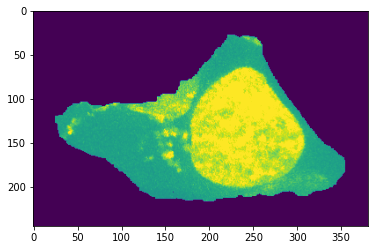

In [32]:
plt.imshow(img_data[1].max(axis=0))
plt.show()

In [33]:
projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
]

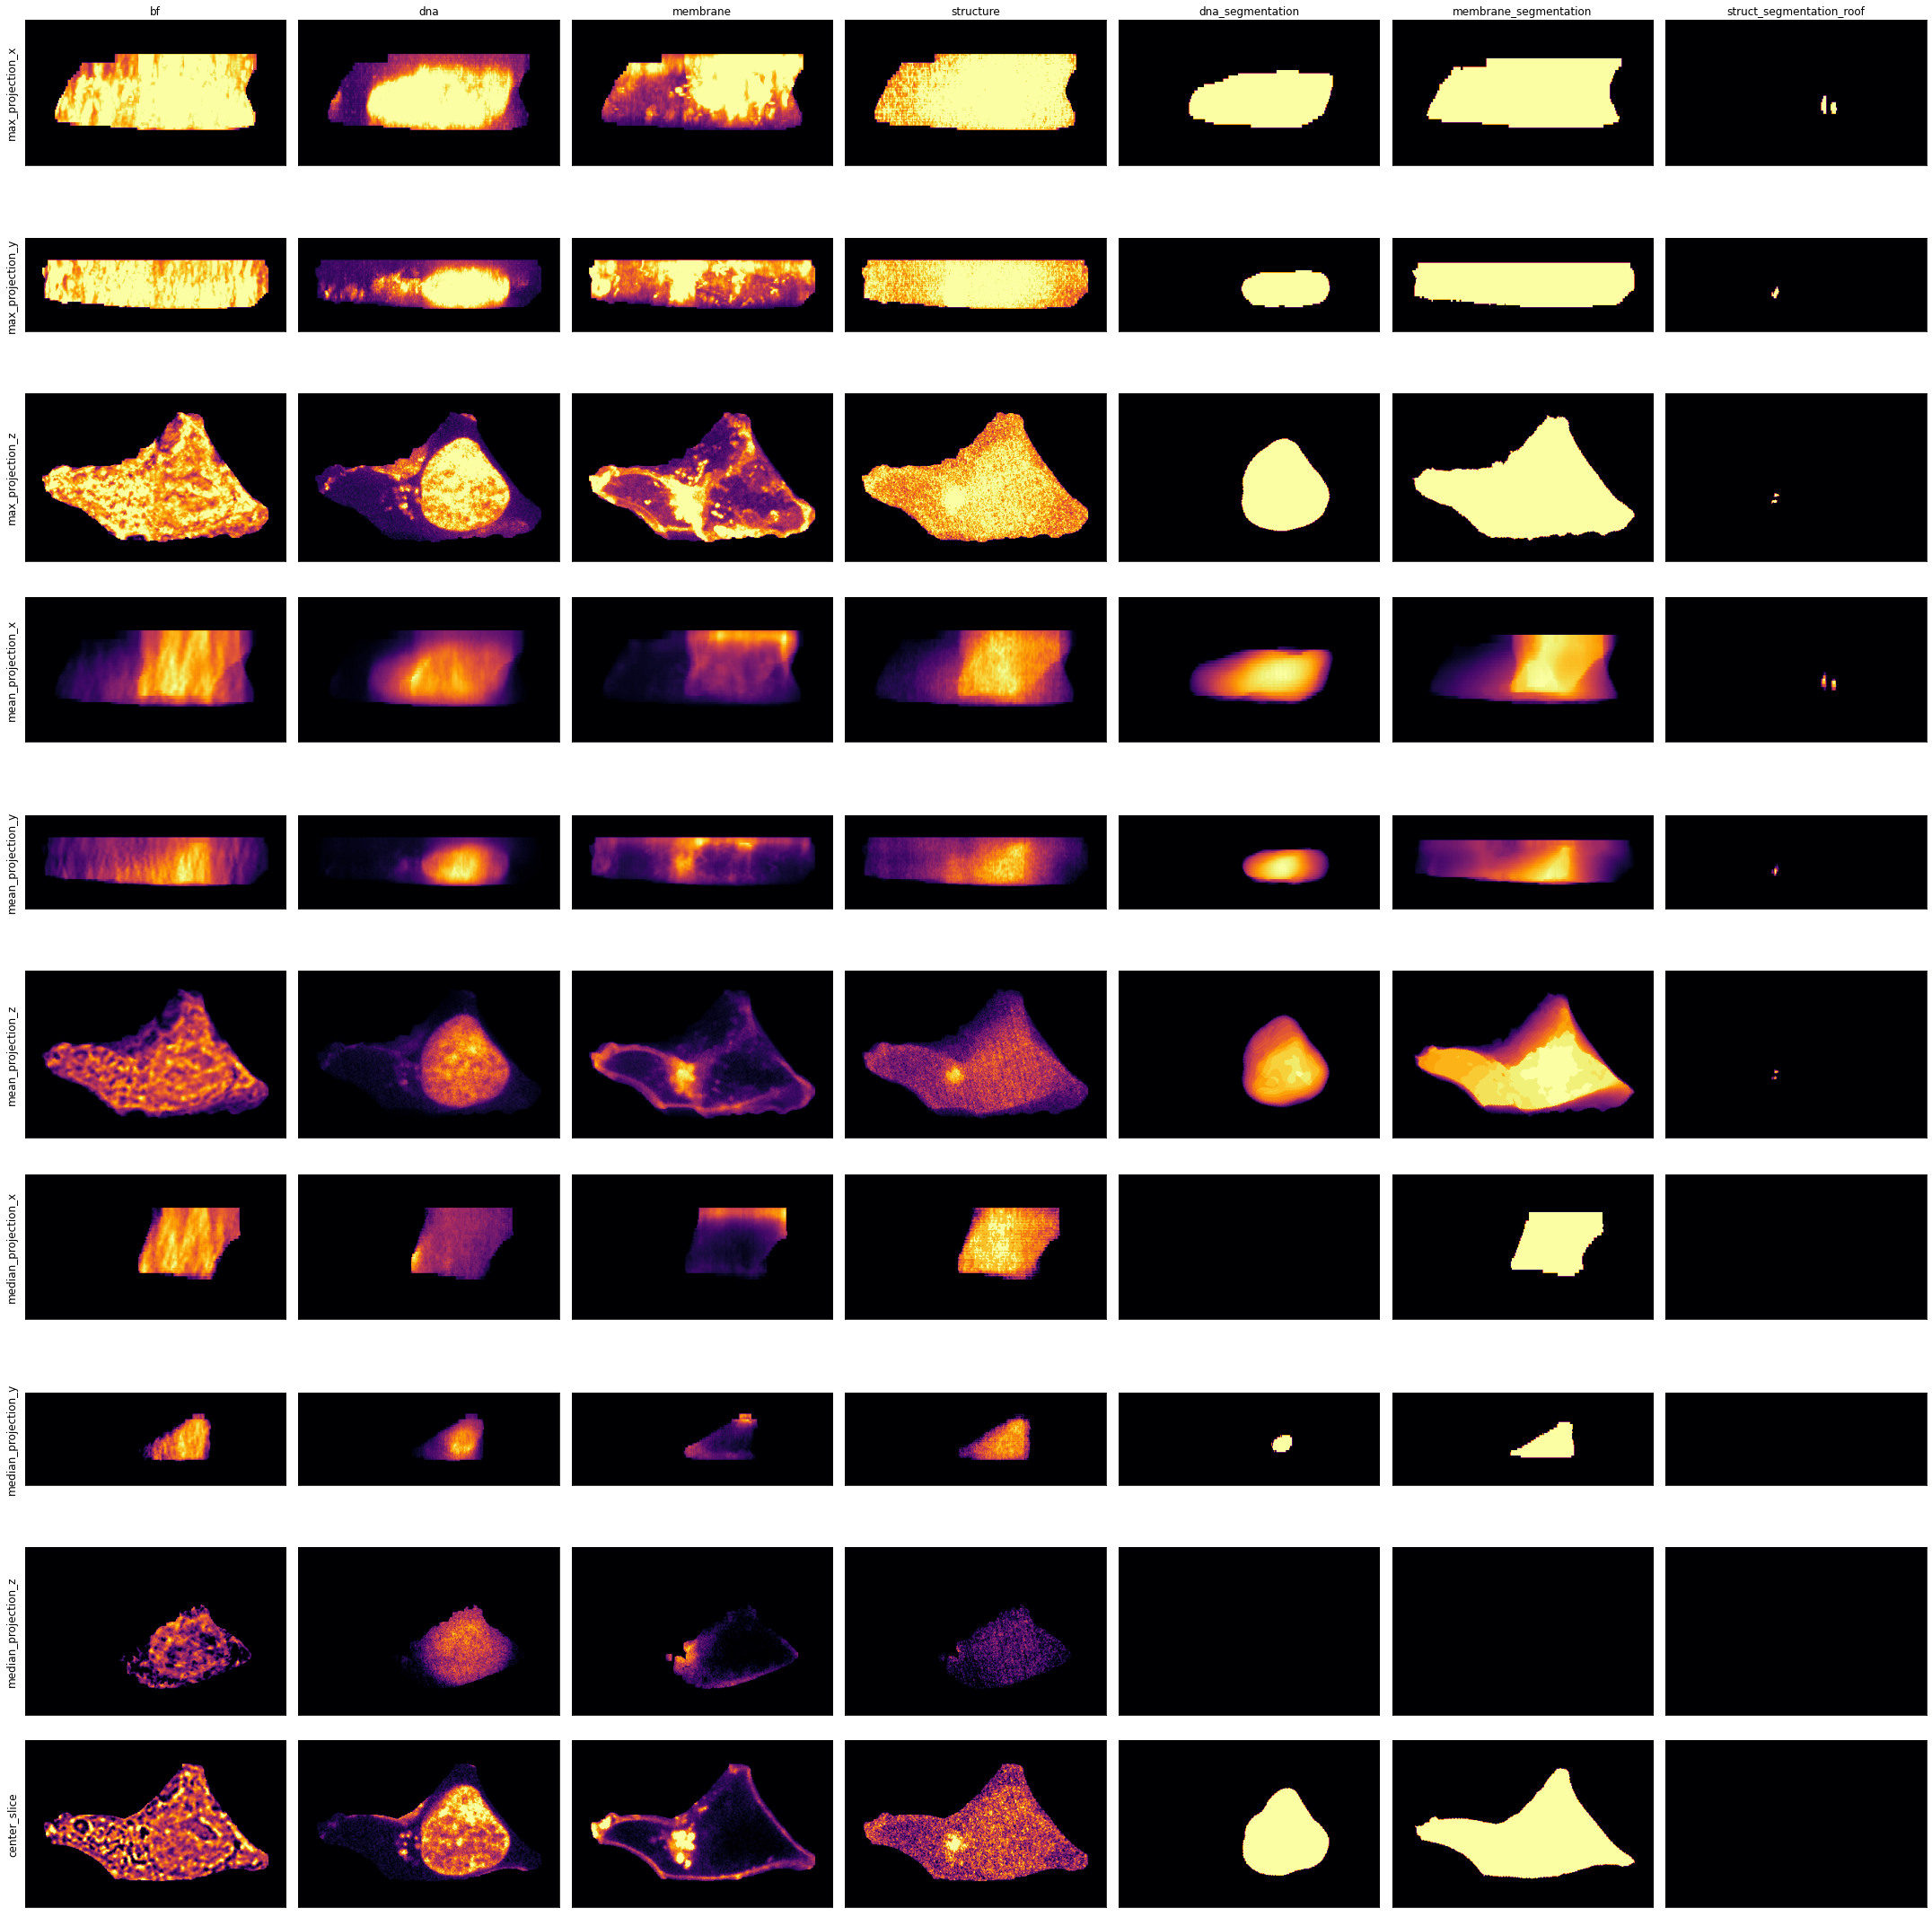

In [34]:
f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix], cmap="inferno")
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()

In [39]:
img = AICSImage(some_cell['max_projection_z'])

/opt/conda/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [40]:
img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']